In [3]:
#! pip uninstall utils

In [1]:
import os
os.chdir("C://Users//malvi//ML_project//table_net//TableNet-pytorch-main//TableNet-pytorch-main//Training")

### install required libraries

In [5]:
! pip install efficientnet_pytorch
! pip install pytorch_model_summary
! pip install tensorboard
! pip install config

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=33c29621deeeef998d16f5bfbc5db126779270616c08d9e2df0fdf080ba2714e
  Stored in directory: c:\users\malvi\appdata\local\pip\cache\wheels\29\16\24\752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet-pytorch


## Importing required libraries

In [2]:
import torch
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import config
import os
from utils import (
    get_data_loaders,
    load_checkpoint,
    save_checkpoint,
    display_metrics,
    write_summary, 
    compute_metrics,
    get_TableMasks,
    fixMasks,
    display
    
    )
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from model import TableNet
from pytorch_model_summary import summary
import tensorboard
from sklearn.model_selection import train_test_split
import albumentations as A 
from albumentations.pytorch import ToTensorV2

### Model Architecture

In [3]:
tableF1, columnF1 = {}, {}

#### DenseNet121

In [12]:
model = TableNet(encoder = 'densenet', use_pretrained_model = True, basemodel_requires_grad = True)

print("Model Architecture and Trainable Paramerters")
print("="*50)
print(summary(model, torch.zeros((1, 3, 1024, 1024)), show_input=False, show_hierarchical=False))

C:\Users\malvi\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\malvi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\malvi/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Model Architecture and Trainable Paramerters
-------------------------------------------------------------------------------------------------------------
      Layer (type)                                              Output Shape         Param #     Tr. Param #
        DenseNet-1     [1, 256, 64, 64], [1, 512, 32, 32], [1, 1024, 32, 32]       6,951,808       6,951,808
          Conv2d-2                                          [1, 256, 32, 32]         262,400         262,400
            ReLU-3                                          [1, 256, 32, 32]               0               0
         Dropout-4                                          [1, 256, 32, 32]               0               0
          Conv2d-5                                          [1, 256, 32, 32]          65,792          65,792
            ReLU-6                                          [1, 256, 32, 32]               0               0
         Dropout-7                                          [1, 256, 32, 32]      

In [ ]:
model = model.to(config.DEVICE)



#load checkpoint
last_epoch, tr_metrics,te_metrics = load_checkpoint(torch.load("C://Users//malvi//.cache//torch//hub//checkpoints//densenet121-a639ec97.pth.tar"), model)
tableF1['Densenet-121'] = te_metrics['table_f1']
columnF1['Densenet-121'] = te_metrics['col_f1']

display_metrics(last_epoch, tr_metrics,te_metrics)

### Performance Comparison

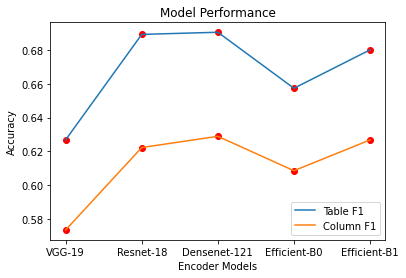

In [13]:
table_x = list(tableF1.keys())
table_y = list(tableF1.values())
col_x = list(columnF1.keys())
col_y = list(columnF1.values())

# plotting scatter plot
plt.scatter(table_x, table_y, color = 'r')
plt.plot(table_x, table_y, label = 'Table F1')

plt.scatter(col_x, col_y, color = 'r')
plt.plot(col_x, col_y, label = 'Column F1')

plt.xlabel('Encoder Models')
plt.ylabel('Accuracy')
plt.title('Model Performance')
plt.legend()
plt.show()

In [14]:
from prettytable import PrettyTable
# http://zetcode.com/python/prettytable/

x = PrettyTable()
x.field_names = ["Model","Table F1", "Column F1"]
x.add_row(['VGG19','0.632','0.573'])
x.add_row(['Resnet18','0.689','0.622'])
x.add_row(['Densenet121','0.691','0.629'])
x.add_row(['EfficientNet-B0','0.657','0.609'])
x.add_row(['EfficientNet-B1','0.68','0.627'])
print(x)

+-----------------+----------+-----------+
|      Model      | Table F1 | Column F1 |
+-----------------+----------+-----------+
|      VGG19      |  0.632   |   0.573   |
|     Resnet18    |  0.689   |   0.622   |
|   Densenet121   |  0.691   |   0.629   |
| EfficientNet-B0 |  0.657   |   0.609   |
| EfficientNet-B1 |   0.68   |   0.627   |
+-----------------+----------+-----------+


DenseNet121 has higher Table F1 score, which directly corresponds to its high Column F1 score

### Load Model

In [15]:
model = TableNet(encoder = 'densenet', use_pretrained_model = True, basemodel_requires_grad = True)
model = model.to(config.DEVICE)

#load checkpoint
_,_,_ = load_checkpoint(torch.load("densenet_model_checkpoint.pth.tar"), model)

Loading checkpoint...


### Load Test data

In [16]:
processed_data = pd.read_csv(config.DATAPATH)
_, test_data  = train_test_split(processed_data, test_size = 0.2, random_state = config.SEED, stratify = processed_data.hasTable)

### Generate output of 10 images

Test Image : 1


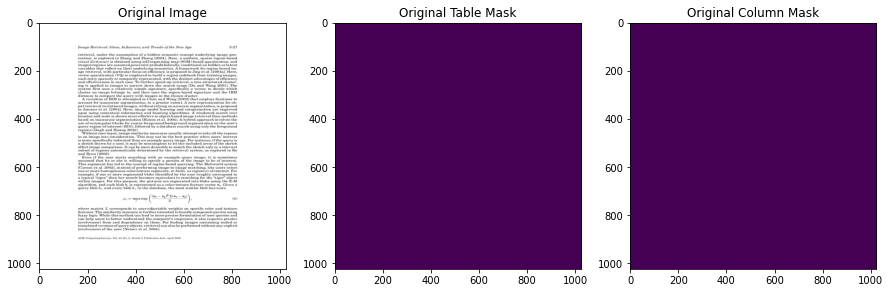

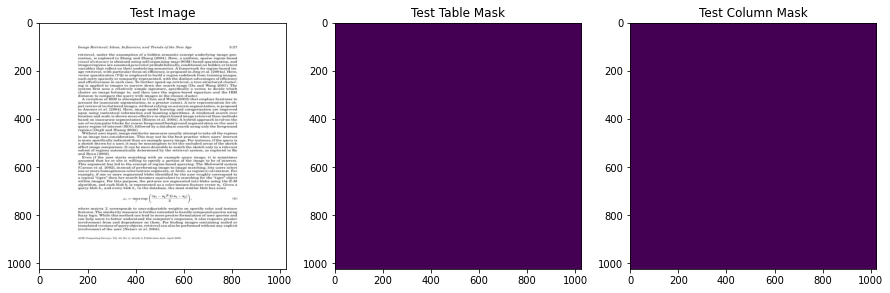

Test Image : 2


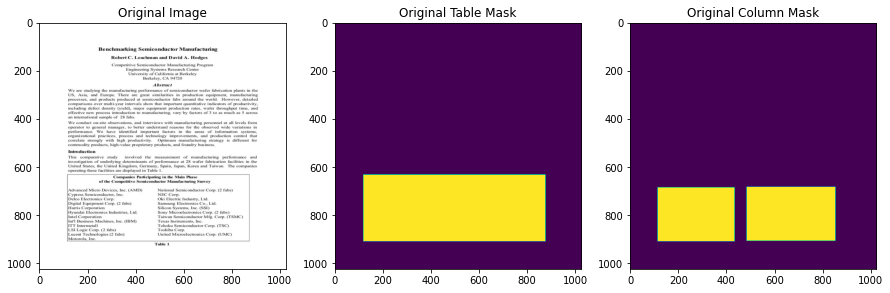

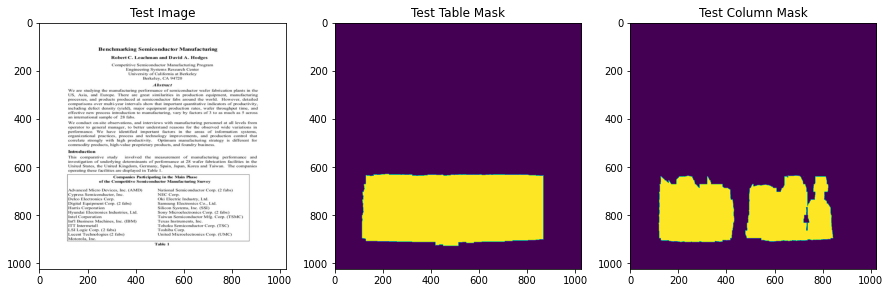

Test Image : 3


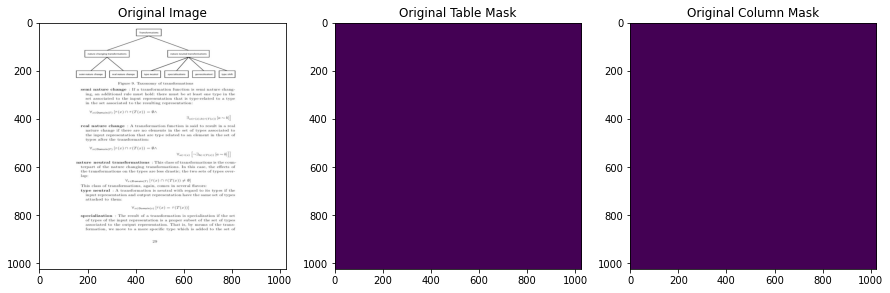

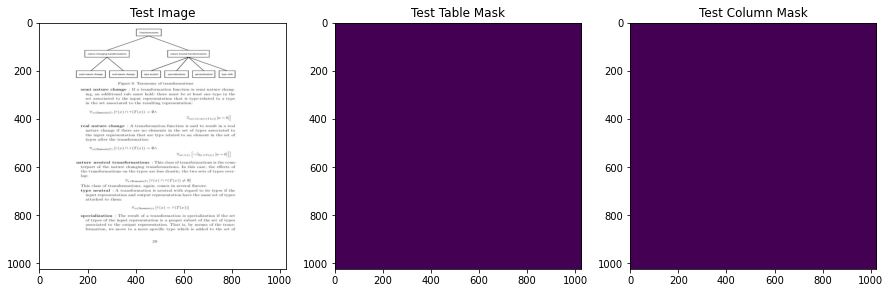

Test Image : 4


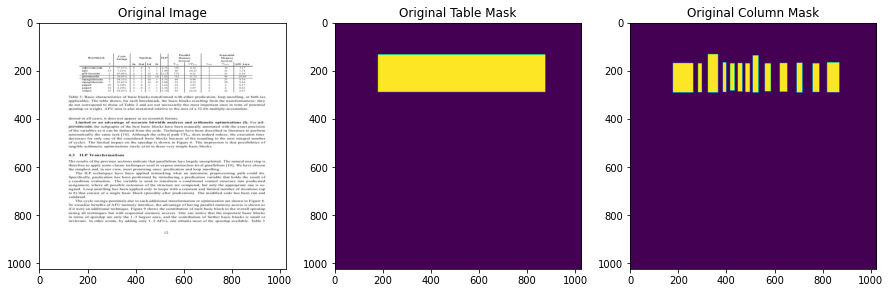

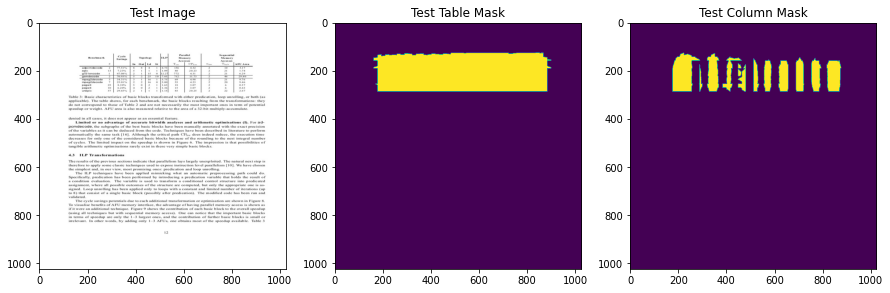

Test Image : 5


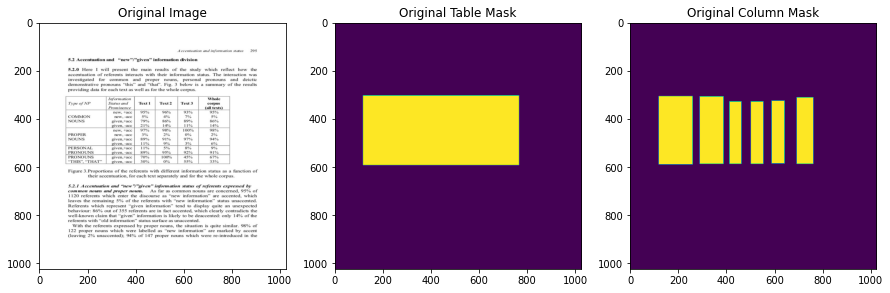

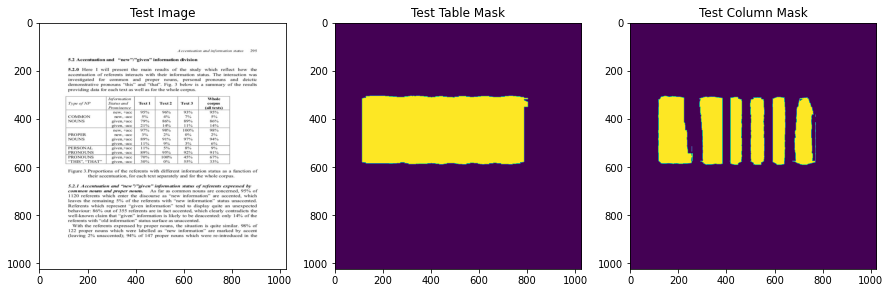

Test Image : 6


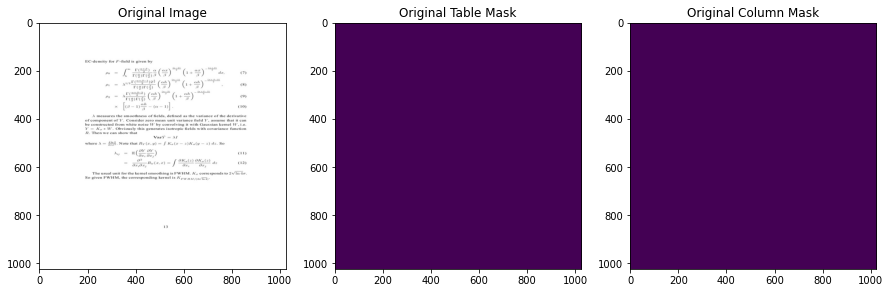

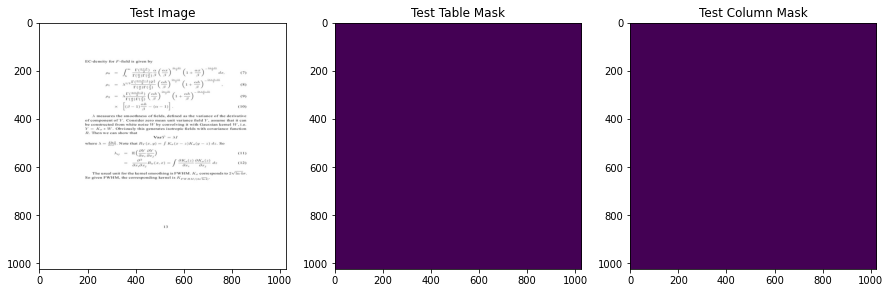

Test Image : 7


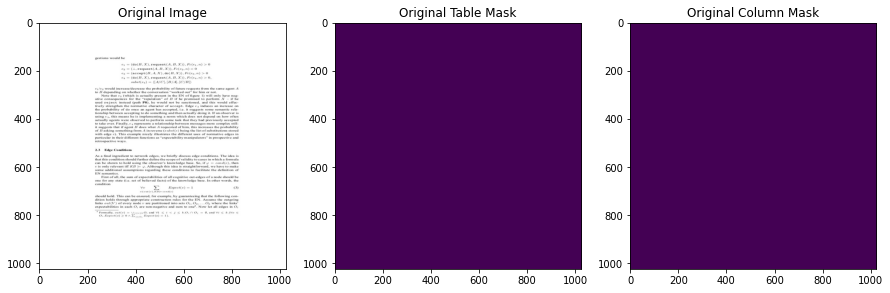

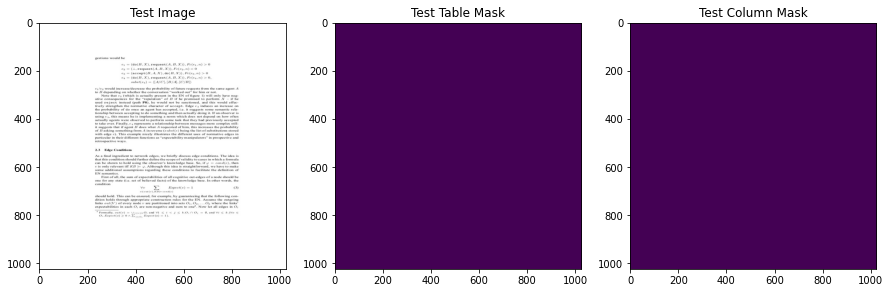

Test Image : 8


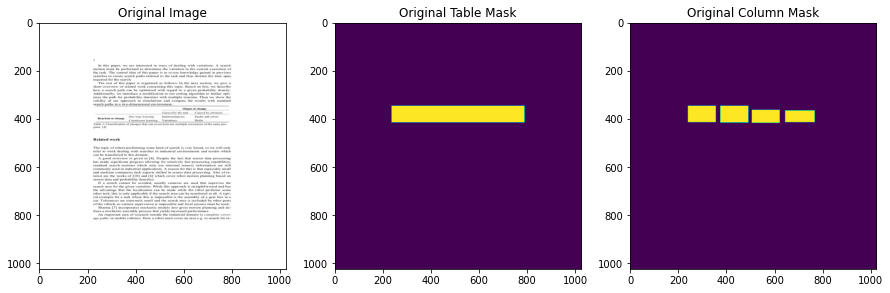

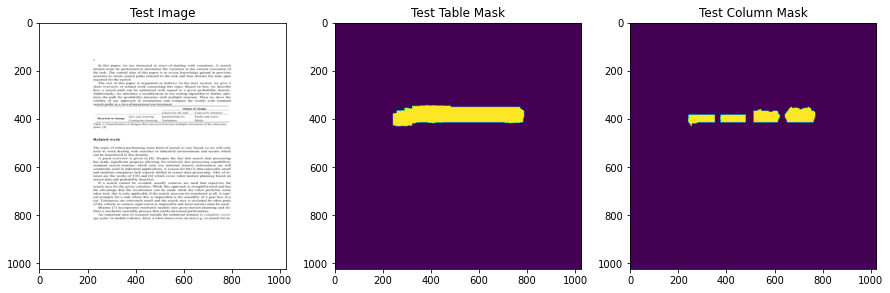

Test Image : 9


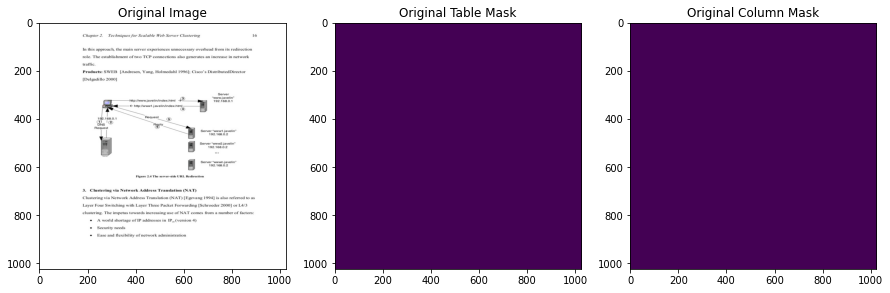

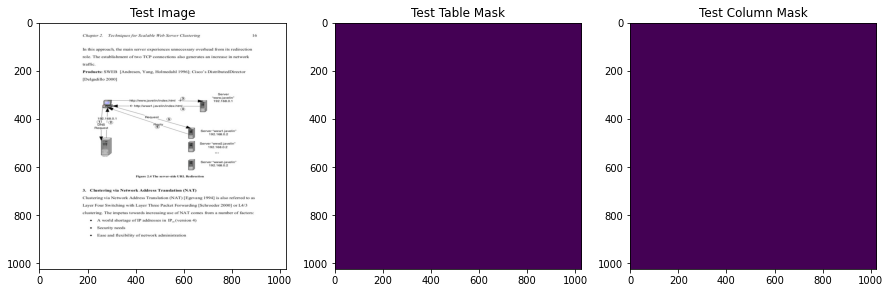

Test Image : 10


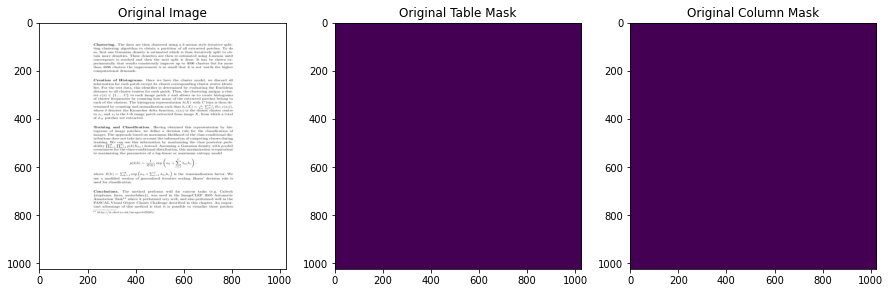

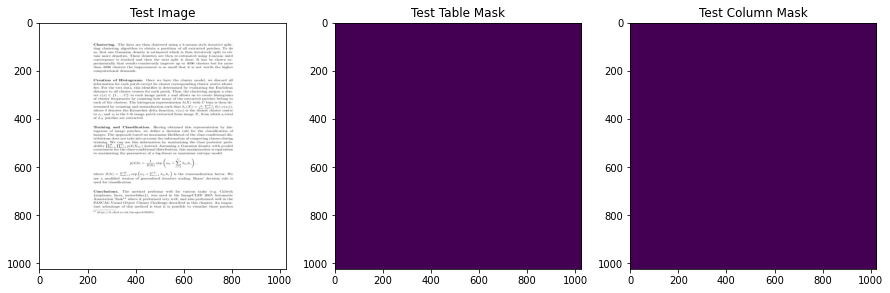

In [17]:
for i in range(10):
    
    print("Test Image :",i+1)
    test_img = np.array(Image.open('../'+ test_data.iloc[i,0]))
    test_table = np.array(Image.open('../'+ test_data.iloc[i,1]))
    test_col = np.array(Image.open('../'+ test_data.iloc[i,2]))

    display(test_img, test_table, test_col, title = 'Original')
    
    table_out, column_out = get_TableMasks(test_img, model)
    
    display(test_img, table_out, column_out, title = 'Test')

### Prediction

In [18]:
import pytesseract
from io import StringIO

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [19]:
def getPredictions(image, table_boundRect):
    #Get output of multiple Tables in an Image and save it to csv

    for i,(x,y,w,h) in enumerate(table_boundRect):
        image_crop = image[y:y+h,x:x+w]
        plt.figure()
        plt.imshow(image_crop)
        plt.show()
        data = pytesseract.image_to_string(image_crop)
        df = pd.read_csv(StringIO(data),sep=r'\|',lineterminator=r'\n',engine='python')
        df.to_csv(f'Table_{i+1}.csv')
        print(df)

##### sample test data - 1

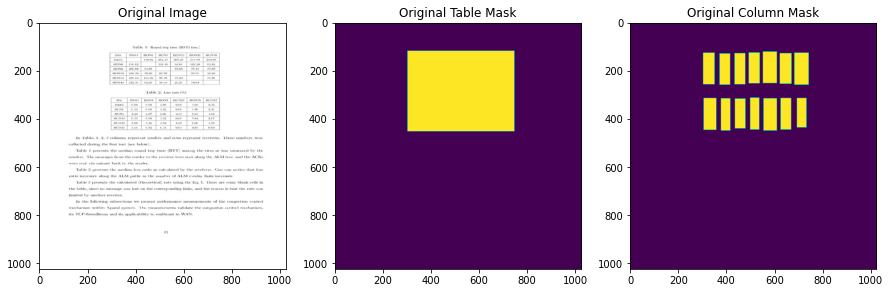

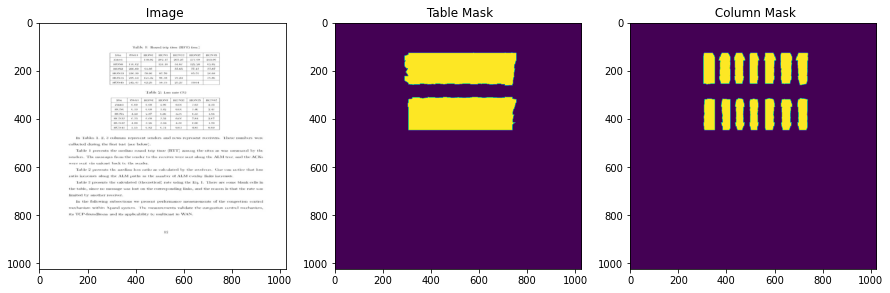

In [20]:
test_img = np.array(Image.open('../'+ test_data.iloc[10,0]))
test_table = np.array(Image.open('../'+ test_data.iloc[10,1]))
test_col = np.array(Image.open('../'+ test_data.iloc[10,2]))

display(test_img, test_table, test_col, title = 'Original')

table_out, column_out = get_TableMasks(test_img, model)
display(test_img, table_out, column_out, title = '')

##### Preprocess and output

In [22]:
outputs = fixMasks(test_img, table_out, column_out)

if outputs is None:
    print("No Tables Found")

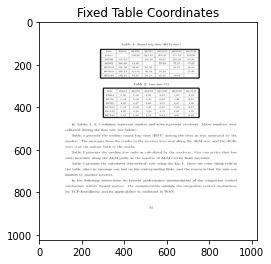

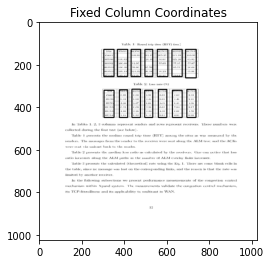

In [24]:
test_image = test_img[...,0].reshape(1024, 1024).astype(np.uint8)

image, table_boundRect, col_boundRects = outputs

#draw bounding boxes of Table Coordinates
color = (0,255,0)
thickness = 4

t_image = test_image.copy()
for x,y,w,h in table_boundRect:
    t_image = cv2.rectangle(t_image, (x,y),(x+w,y+h), color, thickness)

#plot bounding box using table mask
plt.figure()
plt.imshow(t_image, cmap = 'gray')
plt.title('Fixed Table Coordinates')
plt.show()

#Fix Column Coordinates

t_image = test_image.copy()
for c_bbox in col_boundRects:
    for x,y,w,h in c_bbox:
        t_image = cv2.rectangle(t_image, (x,y),(x+w,y+h), color, thickness)

#plot bounding box using table mask
plt.figure()
plt.imshow(t_image, cmap = 'gray')
plt.title('Fixed Column Coordinates')
plt.show()

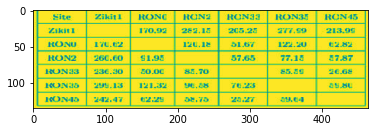

          Site       zimitt          RONC          RON2   RONG    RONSE   \
0  went 110.92       262.15     205.25 co         213.09   None      NaN   
1         KONG    17.02 mua          orev          1220     eae      NaN   
2         RON2       260.60    61.95 3765          774s    8787      NaN   
3         ONas       2a¢.30          F000    82.70 eoes    2668      NaN   
4  HONGS veces     vexs euau          None          None   None      NaN   
5     HONS ove         zozr           avea          None   None      NaN   

    RONA5  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
5     NaN  


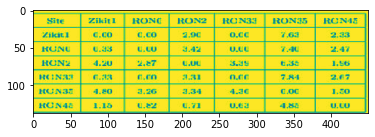

    site    zit    RONG   RON2           RONS    RONG [ RONIE
0   went    ceo     ceo    290     oce 168 288            NaN
1   Kone    oss     coo    saz     one 7au zai            NaN
2   Renz     40    227 [   coo        sav 8 16            NaN
3   kona    ean      en    aaa      ace TR 267            NaN
4  wons:    aso     azo    asa    ase coe 1.20            NaN
5  woNae    120     cee     on      vex ase uw            NaN


In [25]:
getPredictions(test_image, table_boundRect)

##### sample test data - 2

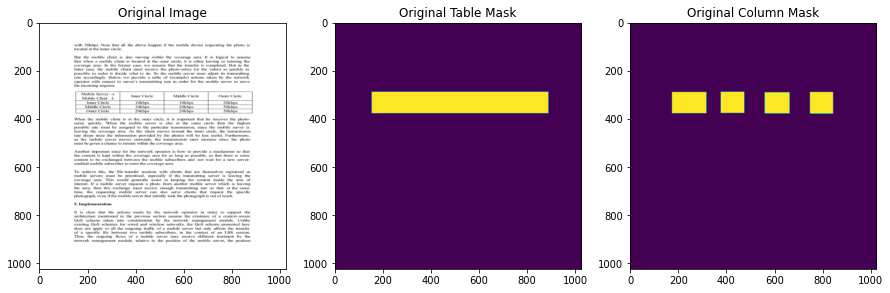

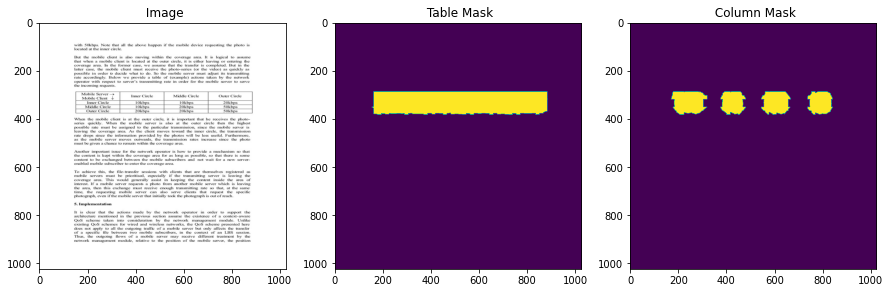

In [26]:
test_img = np.array(Image.open('../'+ test_data.iloc[20,0]))
test_table = np.array(Image.open('../'+ test_data.iloc[20,1]))
test_col = np.array(Image.open('../'+ test_data.iloc[20,2]))

display(test_img, test_table, test_col, title = 'Original')

table_out, column_out = get_TableMasks(test_img, model)
display(test_img, table_out, column_out, title = '')

##### Preprocess and output

In [29]:
outputs = fixMasks(test_img, table_out, column_out)

if outputs is None:
    print("No Tables Found")

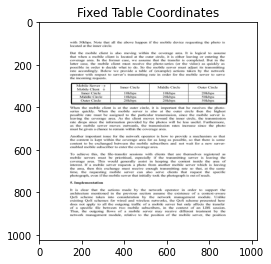

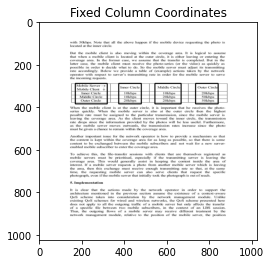

In [30]:
test_image = test_img[...,0].reshape(1024, 1024).astype(np.uint8)

image, table_boundRect, col_boundRects = outputs

#draw bounding boxes of Table Coordinates
color = (0,255,0)
thickness = 4

t_image = test_image.copy()
for x,y,w,h in table_boundRect:
    t_image = cv2.rectangle(t_image, (x,y),(x+w,y+h), color, thickness)

#plot bounding box using table mask
plt.figure()
plt.imshow(t_image, cmap = 'gray')
plt.title('Fixed Table Coordinates')
plt.show()

#Fix Column Coordinates

t_image = test_image.copy()
for c_bbox in col_boundRects:
    for x,y,w,h in c_bbox:
        t_image = cv2.rectangle(t_image, (x,y),(x+w,y+h), color, thickness)

#plot bounding box using table mask
plt.figure()
plt.imshow(t_image, cmap = 'gray')
plt.title('Fixed Column Coordinates')
plt.show()

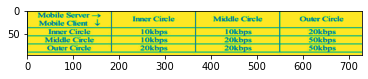

                      Mobile Server >
0                    Mobile Client_ 1
1                        Inner Circle
2                       Middle Circle
3                        Outer Circle
4   Inner Circle TOkbps TOkbps 2OKbps
5  Middle Circle 1Okbps 20kbps S0kbps
6  ‘Outer Circle 20kbps 20kbps SOkbps


In [31]:
getPredictions(test_image, table_boundRect)

##### sample test data - 3

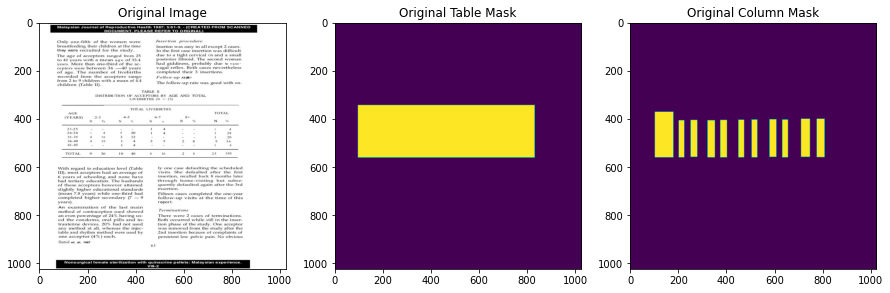

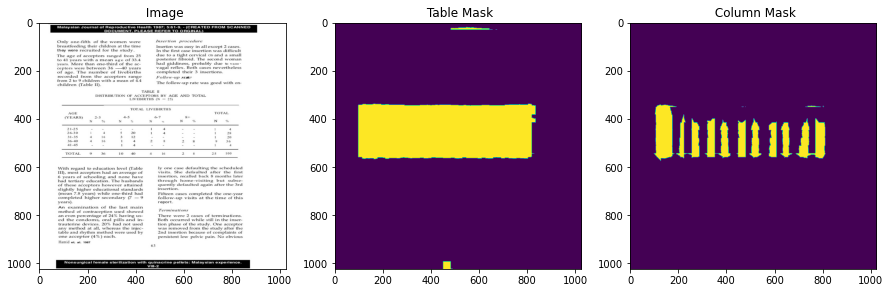

In [32]:
test_img = np.array(Image.open('../'+ test_data.iloc[30,0]))
test_table = np.array(Image.open('../'+ test_data.iloc[30,1]))
test_col = np.array(Image.open('../'+ test_data.iloc[30,2]))

display(test_img, test_table, test_col, title = 'Original')

table_out, column_out = get_TableMasks(test_img, model)
display(test_img, table_out, column_out, title = '')

##### Preprocess and output

In [33]:
outputs = fixMasks(test_img, table_out, column_out)

if outputs is None:
    print("No Tables Found")

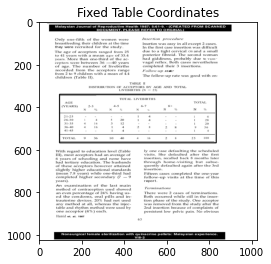

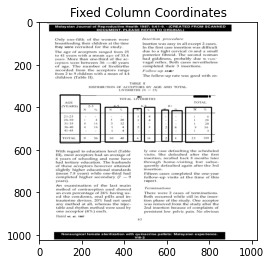

In [34]:
test_image = test_img[...,0].reshape(1024, 1024).astype(np.uint8)

image, table_boundRect, col_boundRects = outputs

#draw bounding boxes of Table Coordinates
color = (0,255,0)
thickness = 4

t_image = test_image.copy()
for x,y,w,h in table_boundRect:
    t_image = cv2.rectangle(t_image, (x,y),(x+w,y+h), color, thickness)

#plot bounding box using table mask
plt.figure()
plt.imshow(t_image, cmap = 'gray')
plt.title('Fixed Table Coordinates')
plt.show()

#Fix Column Coordinates

t_image = test_image.copy()
for c_bbox in col_boundRects:
    for x,y,w,h in c_bbox:
        t_image = cv2.rectangle(t_image, (x,y),(x+w,y+h), color, thickness)

#plot bounding box using table mask
plt.figure()
plt.imshow(t_image, cmap = 'gray')
plt.title('Fixed Column Coordinates')
plt.show()

In [35]:
getPredictions(test_image, table_boundRect)

             LIVEBIRTHS
0              GE TOTAL
1  (YEARS) 23 45 6-7 8+
2         ° N % N " N %
3           - - - 1 4 4
4       4 5 20 1 4 1 28
5      16 3 12 - - 1 20
6       16 1 4 2 8 9 36
7         - 1 4 . = 1 4
8  36 10 40 4 16 25 100


### Samples with No Tables

##### sample test data - 4

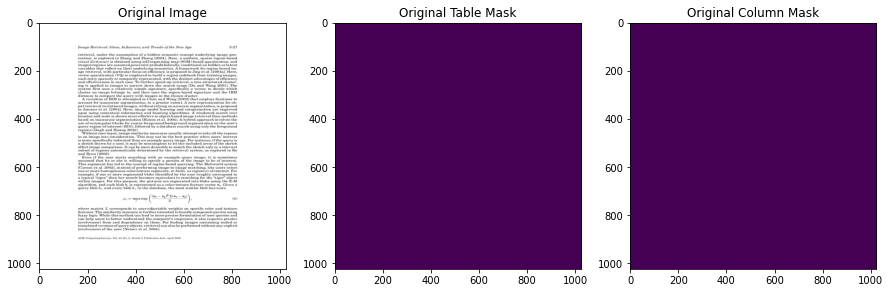

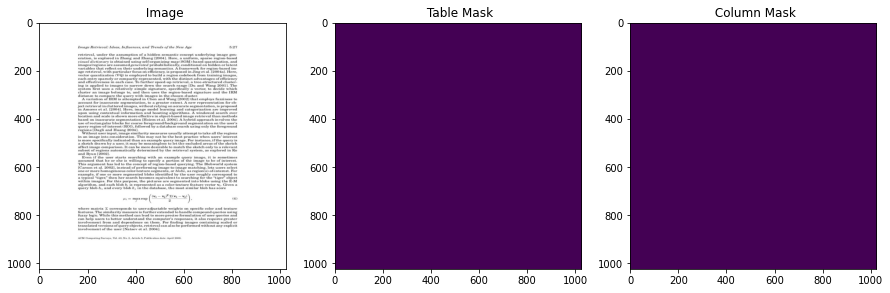

In [37]:
test_img = np.array(Image.open('../'+ test_data.iloc[0,0]))
test_table = np.array(Image.open('../'+ test_data.iloc[0,1]))
test_col = np.array(Image.open('../'+ test_data.iloc[0,2]))

display(test_img, test_table, test_col, title = 'Original')

table_out, column_out = get_TableMasks(test_img, model)
display(test_img, table_out, column_out, title = '')

##### Preprocess and output

In [38]:
outputs = fixMasks(test_img, table_out, column_out)

if outputs is None:
    print("No Tables Found")

No Tables Found


##### sample test data - 5

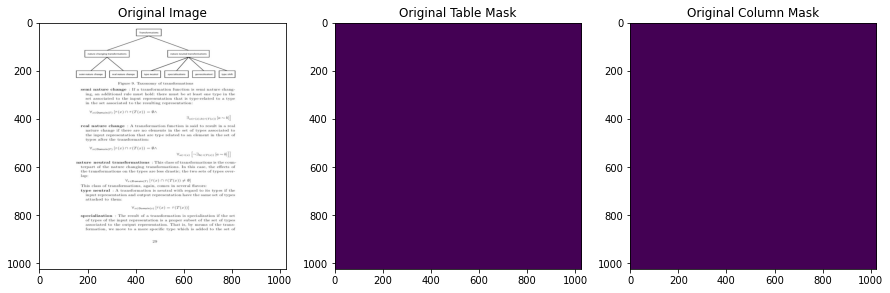

In [39]:
test_img = np.array(Image.open('../'+ test_data.iloc[2,0]))
test_table = np.array(Image.open('../'+ test_data.iloc[2,1]))
test_col = np.array(Image.open('../'+ test_data.iloc[2,2]))

display(test_img, test_table, test_col, title = 'Original')

table_out, column_out = get_TableMasks(test_img, model)
display(test_img, table_out, column_out, title = '')